<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+0"><center> Demonstrations of RADOM on a simulation </center></font> 

# Load packages

In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.06.07


In [3]:
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import copy
from sklearn.decomposition import PCA
import cmasher as cmr
import anndata as ad

In [4]:
plt.rcParams['font.size'] = '24'
label_font = '36'

In [5]:
from RADOM.models.two_species_ss import get_Y, get_y_jac

def generate_y(topo, tau, m=101, p=20, loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, rd_var=0.25, random_seed=42, plot=True):    
    np.random.seed(random_seed)
    L=len(topo)
    assert L == 1
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    
    theta=np.zeros((p,n_states+2))
    theta[:,:n_states]=np.random.lognormal(loga_mu, loga_sd,size=(p,n_states))
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    
    Y = np.zeros((L*m,p,2))
    dY_dtheta = np.zeros((L*m,p,2,n_states+2))
    true_t = np.zeros((L*m))
    t=np.linspace(tau[0],tau[-1],m)
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        for j in range(p):
            y, dy_dtheta = get_y_jac(theta_l[j],t,tau) # m*2*len(theta)
            Y[l*m:(l+1)*m,j] = y # m*p*2
            dY_dtheta[l*m:(l+1)*m,j] = dy_dtheta
        true_t[l*m:(l+1)*m] = t
        
    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
            
    return theta, true_t, Y, dY_dtheta

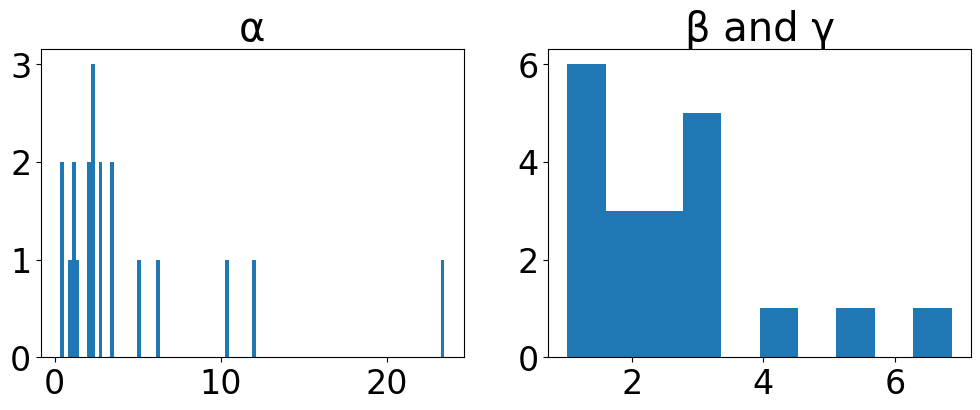

In [6]:
true_topo=np.array([[0,1]])
topo=np.array([[0,1]])
tau=(0,1)
m=101
L=len(topo)
true_theta, true_t, Y, dY_dtheta = generate_y(true_topo, tau, m=m, p=10, random_seed=42)

# Fisher information matrix given time

In [7]:
n=1000
rd_var=0
if rd_var != 0:
    read_depth = np.random.gamma(1/rd_var,rd_var,n)
    rd = read_depth/read_depth.mean()
else:
    rd = np.ones(n)

In [8]:
n=1000
p, n_theta = true_theta.shape
FIM = np.zeros((p,len(Y),n_theta,n_theta))
for j in range(p):
    for i in range(len(Y)):
        y = Y[i,j] #2
        dy_dtheta = dY_dtheta[i,j] #2*n_theta
        I = np.zeros((n_theta,n_theta))
        for k in range(n):
            x = np.random.poisson(y)
            d = np.sum((x/y-1)[:,None]*dy_dtheta,axis=0).reshape((-1,1))
            I += d@d.T/n
        FIM[j,i] = I

In [10]:
FIM_eigs = np.linalg.eigvals(FIM)
FIM_eigs.shape

(10, 101, 4)

In [11]:
FIM_eigs.sum(axis=-1)

array([[ 2.25029661+0.j,  2.61357414+0.j,  2.58403406+0.j, ...,
         3.22925545+0.j,  2.83827048+0.j,  3.18193625+0.j],
       [ 7.38059555+0.j,  8.48752493+0.j,  7.53272289+0.j, ...,
         9.0550555 +0.j,  9.25185527+0.j,  9.35676777+0.j],
       [ 1.38847912+0.j,  1.28081637+0.j,  1.26471863+0.j, ...,
         1.17876434+0.j,  1.07261963+0.j,  1.16965145+0.j],
       ...,
       [11.06664638+0.j, 12.28879089+0.j, 11.0055368 +0.j, ...,
         3.44171045+0.j,  3.71650736+0.j,  3.49376126+0.j],
       [ 7.60661766+0.j,  7.01390871+0.j,  7.33819529+0.j, ...,
         4.32793038+0.j,  4.45083224+0.j,  4.33552935+0.j],
       [ 1.19405058+0.j,  1.32884349+0.j,  1.30317985+0.j, ...,
         0.971689  +0.j,  0.95960736+0.j,  0.89807232+0.j]])

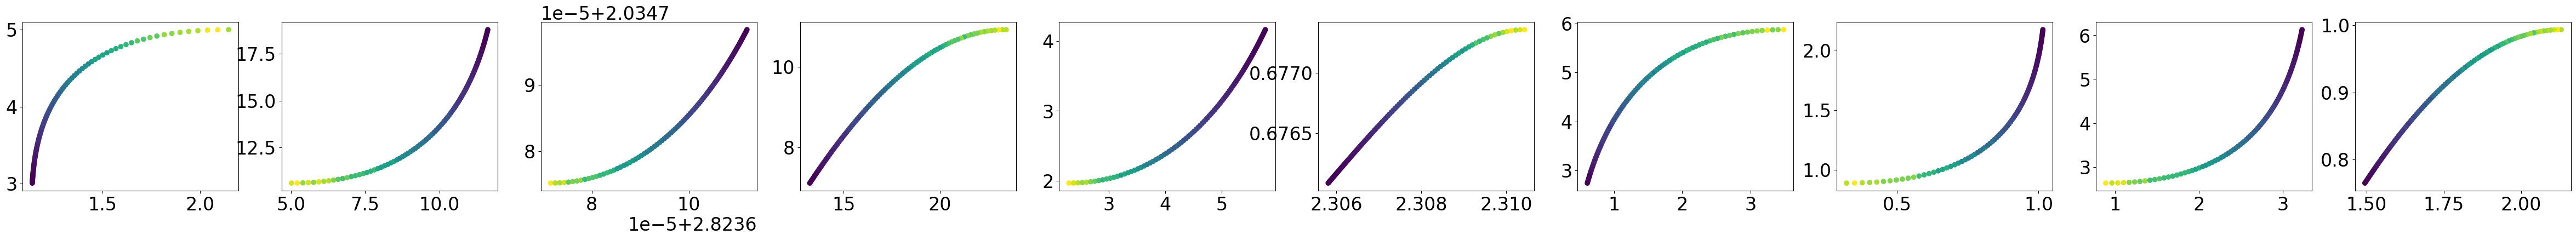

In [12]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    #ax[j].scatter(Y[:,j,0],Y[:,j,1],c=true_t);
    ax[j].scatter(Y[:,j,0],Y[:,j,1],c=FIM[j,:,0,0]);
# time increases from blue to red

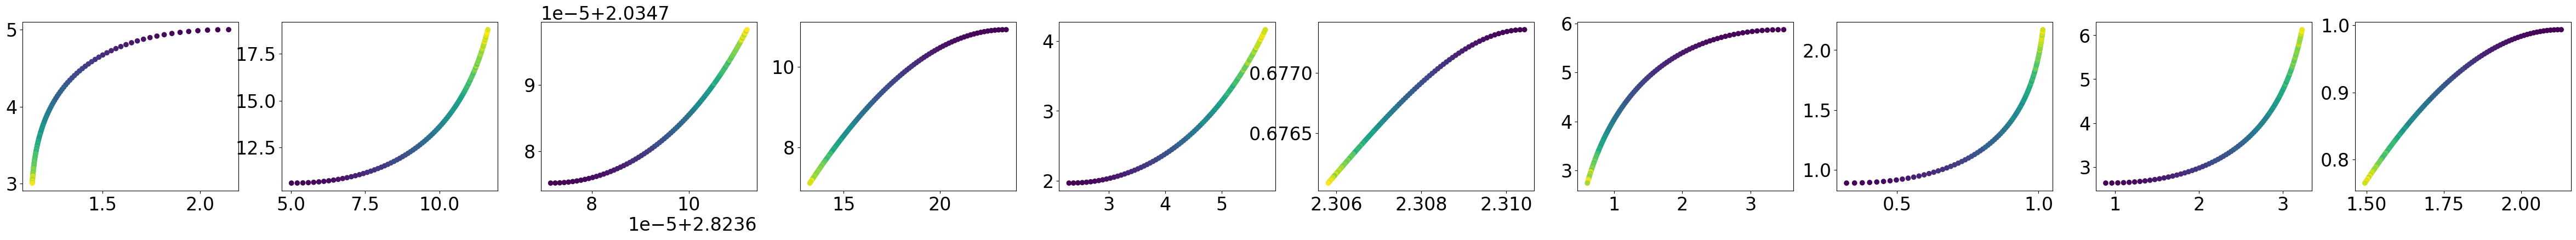

In [13]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    #ax[j].scatter(Y[:,j,0],Y[:,j,1],c=true_t);
    ax[j].scatter(Y[:,j,0],Y[:,j,1],c=FIM[j,:,1,1]);
# time increases from blue to red

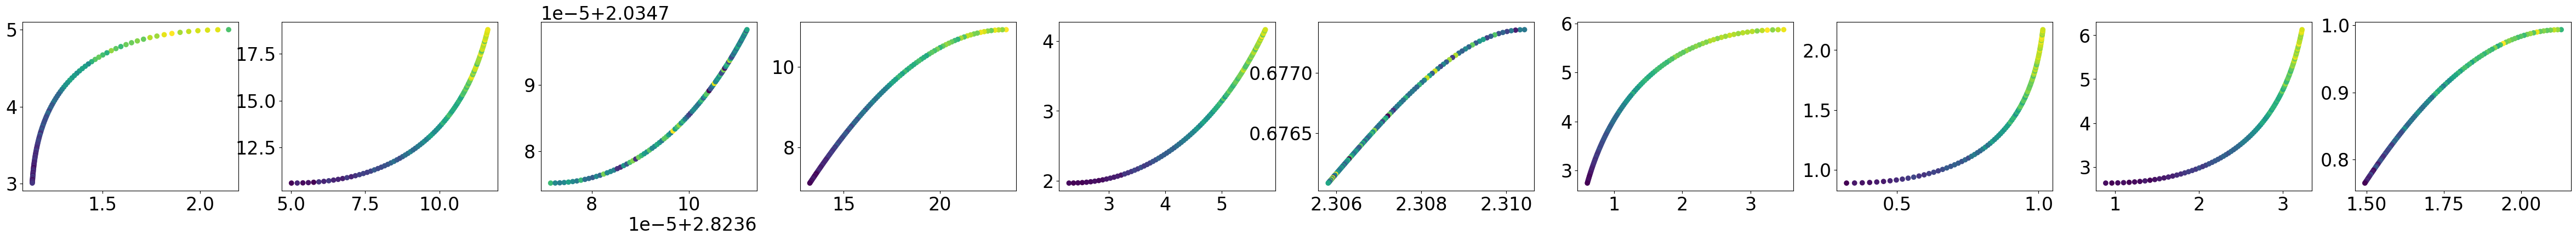

In [14]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    #ax[j].scatter(Y[:,j,0],Y[:,j,1],c=true_t);
    ax[j].scatter(Y[:,j,0],Y[:,j,1],c=FIM[j,:,-2,-2]);
# time increases from blue to red

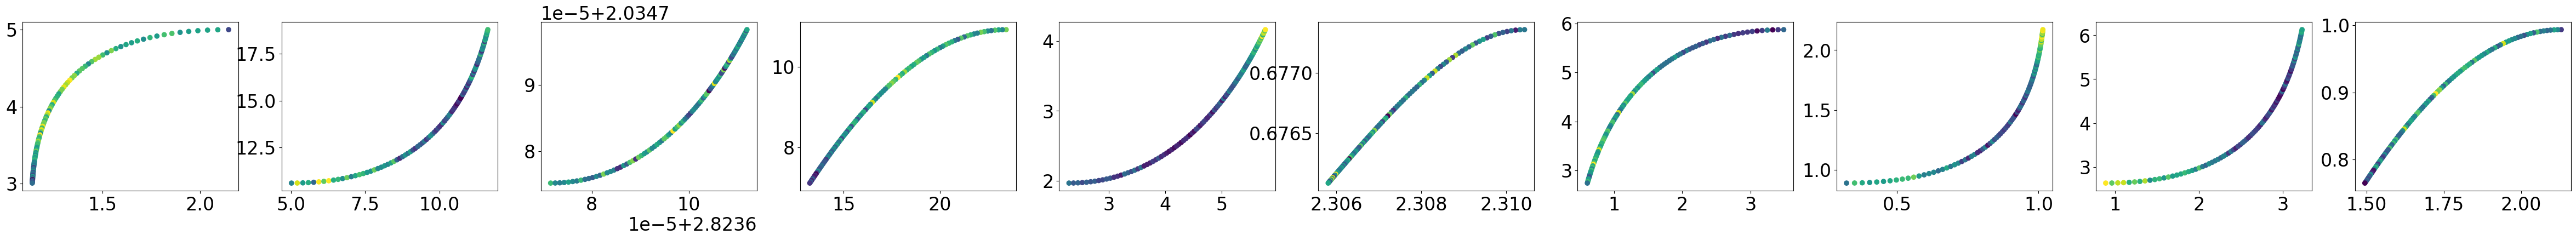

In [15]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    #ax[j].scatter(Y[:,j,0],Y[:,j,1],c=true_t);
    ax[j].scatter(Y[:,j,0],Y[:,j,1],c=FIM[j,:,-1,-1]);
# time increases from blue to red

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4411: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


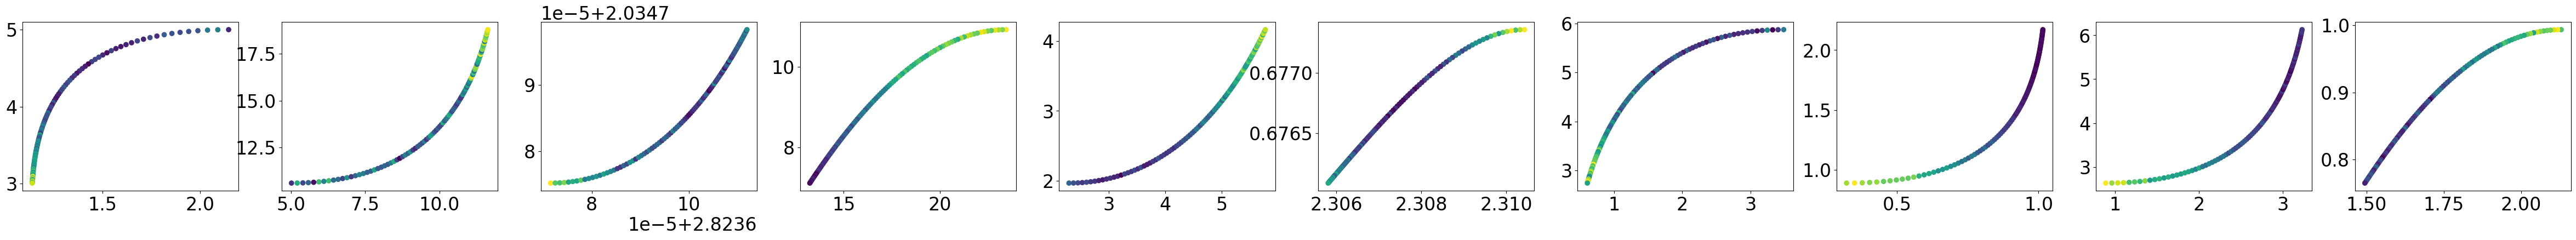

In [16]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    #ax[j].scatter(Y[:,j,0],Y[:,j,1],c=true_t);
    ax[j].scatter(Y[:,j,0],Y[:,j,1],c=FIM_eigs[j].sum(axis=(-1)));
# time increases from blue to red

# Fisher information matrix

In [7]:
def generate_x(topo, tau, m=101, n=1000, p=100, loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, rd_var=0.25, random_seed=42, plot=True):    
    np.random.seed(random_seed)
    L=len(topo)
    assert L == 1
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    
    theta=np.zeros((p,n_states+2))
    theta[:,:n_states]=np.random.lognormal(loga_mu, loga_sd,size=(p,n_states))
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    
    dY_dtheta = np.zeros((L,m,p,2,n_states+2))
    Y_grids = np.zeros((L,m,p,2))
    true_t = []
    t_grids=np.linspace(tau[0],tau[-1],m)
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.sort(np.random.uniform(tau[0],tau[-1],n))
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)
        for j in range(p):
            y, dy_dtheta = get_y_jac(theta_l[j],t_grids,tau) # m*2*len(theta)
            dY_dtheta[l,:,j] = dy_dtheta
            Y_grids[l,:,j] = y
            
    X = np.random.poisson(Y)
    
    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
            
    return theta, true_t, Y, X, Y_grids, dY_dtheta

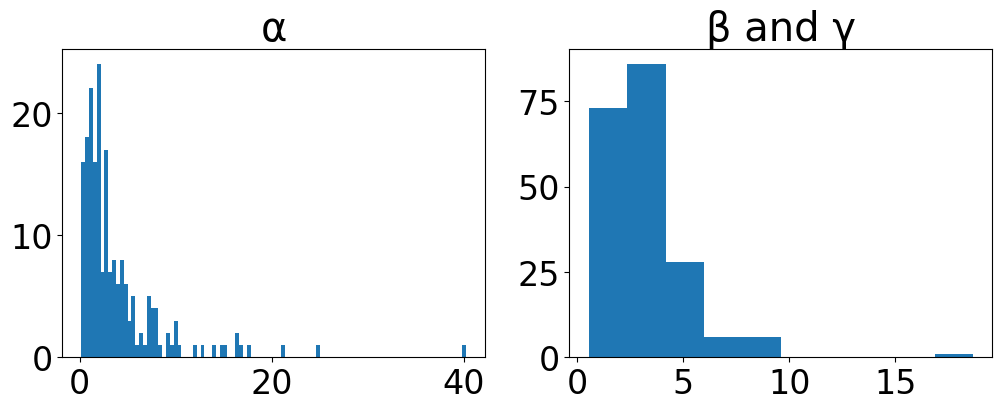

In [8]:
theta, true_t, Y, X, Y_grids, dY_dtheta = generate_x(topo, tau)

In [9]:
traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,warm_start=True,m=101,theta=theta,epoch=0)

fitting with warm start


0it [00:00, ?it/s]


In [12]:
FI = traj.compute_FI(X)
w,v = np.linalg.eig(FI)
v[10,:,-1]

array([-0.1588003 ,  0.04434333,  0.98446233,  0.06041569])

In [12]:
Q = traj.Q.copy()

In [13]:
X.shape, Q.shape, dY_dtheta.shape

((1000, 100, 2), (1000, 1, 101), (1, 101, 100, 2, 4))

In [14]:
n,p = X.shape[:2]
temp = np.sum((X[:,None,None,:,:,None]/Y_grids[None,:,:,:,:,None]-1)*dY_dtheta[None,:],axis=(-2)) 
# temp: (n,L,m,p,2,n_theta) -> (n,L,m,p,n_theta)
temp *= Q[:,:,:,None,None]
temp = np.sum(temp,axis=(1,2)) #(n,p,n_theta)
FI = np.sum(temp[:,:,:,None]*temp[:,:,None,:],axis=0)

In [15]:
w,v = np.linalg.eig(FI)

In [16]:
v[10,:,-1]

array([-0.1588003 ,  0.04434333,  0.98446233,  0.06041569])

In [75]:
theta[10]

array([3.69995066, 0.68174091, 8.6480104 , 1.06861926])

[0.04817514 0.11959224 0.69842099 0.70397796]
[-0.09562566 -0.12881771  0.65608959  0.7374335 ]
[-3.09417065e-07 -2.00589073e-05  6.25920939e-01  7.79886516e-01]
[0.22575534 0.35710007 0.71676958 0.5547571 ]
[-0.02365978 -0.02642293  0.16952569  0.98488735]
[8.45389472e-05 1.34585745e-04 6.02183202e-01 7.98357918e-01]
[0.09878763 0.06732452 0.81795288 0.56272684]
[-0.01212176 -0.10246623  0.42910994  0.89733962]
[ 0.00826231 -0.52951215  0.42027731  0.73682806]
[0.00736427 0.07696365 0.62669467 0.77541999]


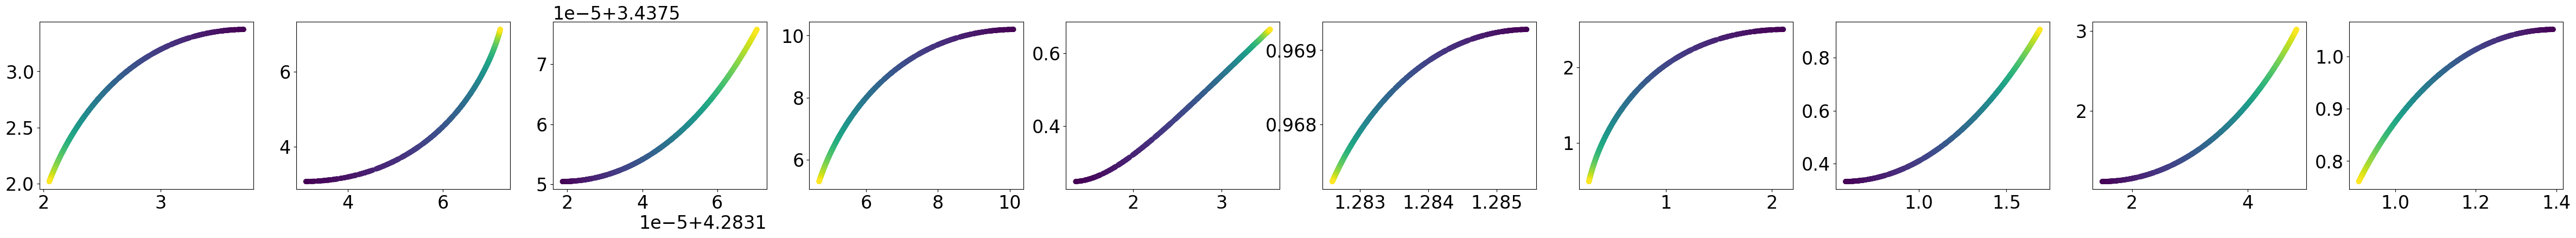

In [81]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for j in range(p):
    ax[j].scatter(Y[:,j,0],Y[:,j,1],c=true_t);
    print(v[j,:,-1])
    #ax[j].scatter(Y[:,j,0],Y[:,j,1],c=FIM[j,:,1,1]);
# time increases from blue to red

In [78]:
v[:,:,0]

array([[-0.38574222, -0.4919825 , -0.4963033 ,  0.60236135],
       [ 0.25668597,  0.37869268,  0.71140071, -0.53349151],
       [-0.19939714, -0.0507397 , -0.76320093,  0.61252804],
       [-0.00498804, -0.00471417,  0.61449587, -0.78889018],
       [-0.34998076, -0.85762255, -0.37536014,  0.03319346],
       [-0.38698813, -0.89217656, -0.18587766,  0.14039467],
       [-0.17114435, -0.97733779,  0.0161261 ,  0.12353302],
       [-0.73197737, -0.53495151, -0.40387263,  0.12215937],
       [ 0.38511564,  0.19433501,  0.83522237, -0.34106222],
       [-0.69274815, -0.58513681, -0.29391956,  0.30220226],
       [ 0.19859475,  0.1143641 ,  0.08632419, -0.96955099],
       [-0.40124999, -0.18710846, -0.20169027,  0.87367609],
       [ 0.4352633 ,  0.37108729,  0.78014763, -0.25339643],
       [-0.64365701, -0.2369301 , -0.52913206,  0.49958887],
       [ 0.45939291,  0.35646812,  0.74926469, -0.31700326],
       [ 0.09944562,  0.06058064,  0.97077949, -0.20982786],
       [-0.43982571, -0.

In [16]:
w[:,-1]/X.shape[0]

array([1.30405207e-03, 2.47330358e-03, 2.02150227e-12, 4.99017288e-03,
       5.08377826e-05, 4.17216681e-09, 5.83375965e-03, 5.52499870e-04,
       2.68301704e-03, 3.08560735e-04, 5.09425781e-03, 8.08156482e-03,
       3.20690348e-04, 6.64863797e-03, 9.12821527e-05, 2.15259699e-03,
       4.70998501e-03, 3.19379562e-03, 6.31774400e-04, 5.48820629e-02,
       1.77561283e-03, 5.59563184e-05, 7.63498064e-04, 5.32933426e-03,
       3.86396437e-03, 4.06952773e-04, 9.32931700e-04, 1.23283876e-04,
       3.56698331e-04, 9.30848991e-02, 2.18982801e-04, 9.10706399e-06,
       4.18816574e-03, 2.80335334e-03, 3.15706689e-03, 7.32678892e-03,
       8.54381400e-03, 3.12557791e-02, 9.25505896e-04, 1.16866329e-02,
       5.94815037e-04, 1.74572101e-02, 5.38083436e-05, 1.61683833e-03,
       4.31676435e-03, 8.31751759e-02, 1.15890118e-01, 3.22577357e-03,
       3.70451015e-06, 1.14245745e-04, 1.67805305e-03, 2.76119832e-04,
       1.09659753e-03, 4.17310482e-01, 5.07657397e-04, 1.00571797e-03,
      